# Idea

In [105]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

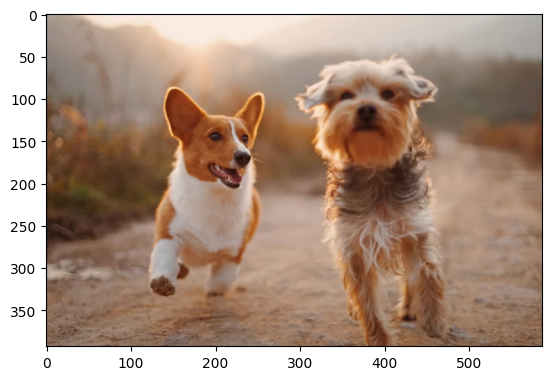

In [106]:
img = cv2.imread('../docs/images/image.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

True

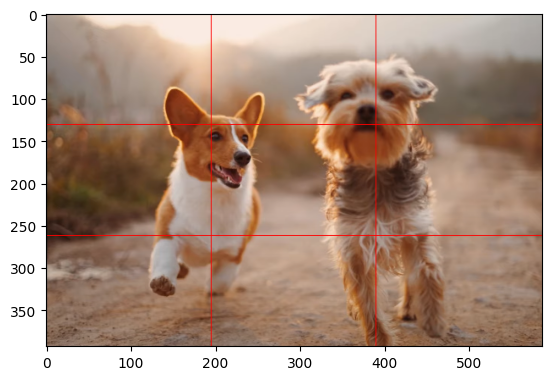

In [107]:
# divide image to 9 regions
rows, cols, _ = img.shape
row = rows // 3
col = cols // 3
# draw lines
for i in range(1, 3):
    cv2.line(img, (0, i * row), (cols, i * row), (255, 0, 0), 1)
    cv2.line(img, (i * col, 0), (i * col, rows), (255, 0, 0), 1)
plt.imshow(img)
#save image
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('../docs/images/split_img.png', img)

Ultralytics YOLOv8.0.25 🚀 Python-3.10.9 torch-1.13.1 CPU
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

0: 448x640 2 dogs, 57.6ms
Speed: 0.4ms pre-process, 57.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to ../docs/images


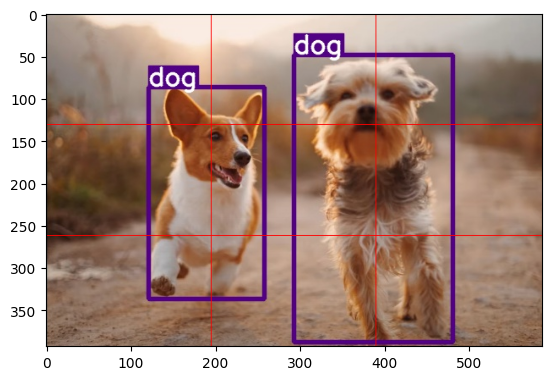

In [108]:
img = cv2.imread('../docs/images/image.png')
model = YOLO('yolov8n.pt')
plt.imshow(img)
results = model(img, save=True, project='../docs/', name='images', exist_ok=True,hide_conf=True)
vis = cv2.imread('../docs/images/image0.jpg')
vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
rows, cols, _ = vis.shape
row = rows // 3
col = cols // 3
# draw lines
for i in range(1, 3):
    cv2.line(vis, (0, i * row), (cols, i * row), (255, 0, 0), 1)
    cv2.line(vis, (i * col, 0), (i * col, rows), (255, 0, 0), 1)

plt.imshow(vis)

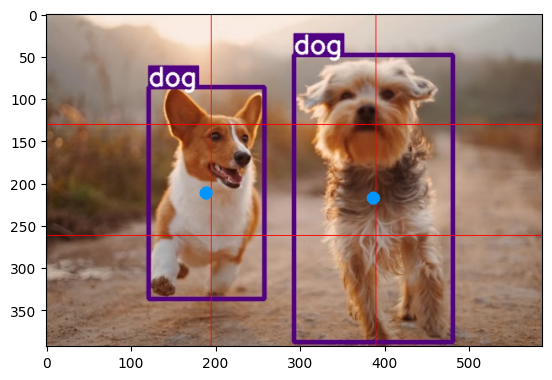

In [109]:
centers = []
for result in results:
    for box in result.boxes:
        x_center, y_center, w, h = box.numpy().xywh[0]
        # draw center point
        cv2.circle(vis, (int(x_center), int(y_center)), 2, (0, 150, 255), 12)
        centers.append((int(x_center), int(y_center), int(w), int(h)))
    
plt.imshow(vis)
# separate image to 9 regions

Image shape:  (393, 587)
Region shape:  (131, 195)
Center xywh:  (189, 212, 137, 250)
Label:  [       0.97        0.62         0.7        1.91]
--------------------
Center xywh:  (387, 218, 188, 339)
Label:  [       0.98        0.66        0.96        2.59]
--------------------


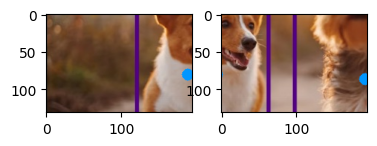

In [110]:
regions = []
responsible_region = []
print('Image shape: ', img.shape[:2]) #image shape

for i in range(3):
    for j in range(3):
        regions.append(vis[i * row:(i + 1) * row, j * col:(j + 1) * col])

print('Region shape: ', regions[0].shape[:2]) #region shape

for i in range(3):
    for j in range(3):
        for center in centers:
            x1, y1, x2, y2 = j*col, i*row, (j+1)*col, (i+1)*row
            x_center, y_center, w, h = center
            if x_center >= x1 and x_center < x2 and y_center >= y1 and y_center < (i + 1) * y2:
                print('Center xywh: ', center) #x_center, y_center, w, h
                result = ((x_center-x1)/col, (y_center-y1)/row, w/col, h/row)
                print('Label: ',np.around(result, 2))
                print('-' * 20)
                responsible_region.append(regions[i * 3 + j])

for i, region in enumerate(responsible_region):
    plt.subplot(3, 3, i + 1)
    plt.imshow(region)

# Model

In [111]:
import torch.nn as nn
import torch

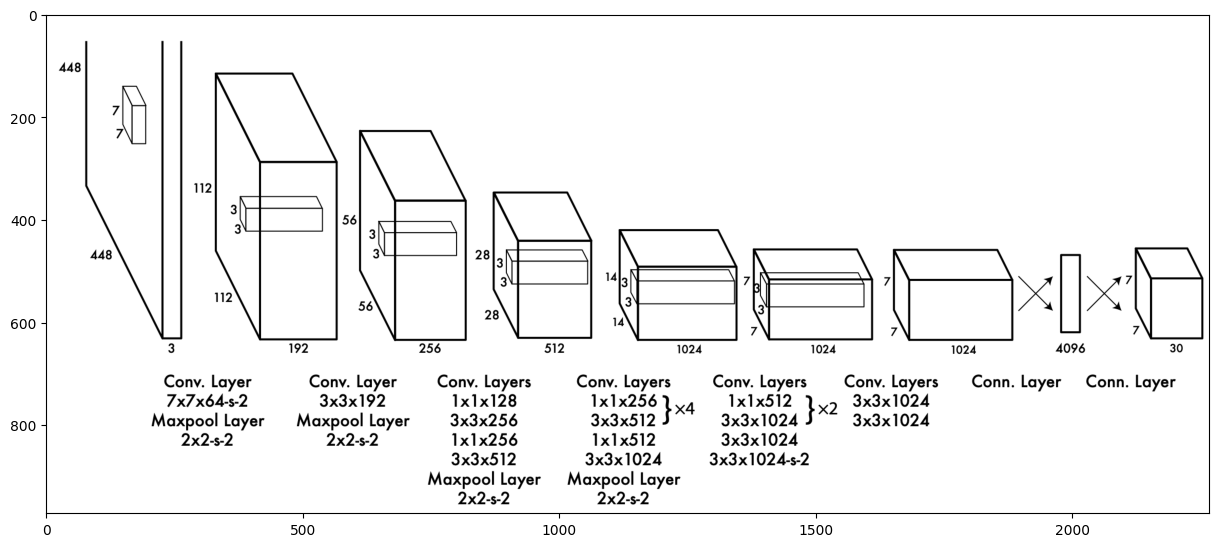

In [112]:
model_architecture_img = cv2.imread('../docs/images/model_architecture.png')
model_architecture_img = cv2.cvtColor(model_architecture_img, cv2.COLOR_BGR2RGB)
#extend coordinates display
plt.figure(figsize=(15, 15))
plt.imshow(model_architecture_img)



In [113]:
architecture_config = [
    # Tuple: (kernel_size, filter, stride, padding)
    (7, 64, 2, 3),                          #[2, 64, 224, 224]
    'M',                                    #[2, 64, 112, 112]
    (3, 192, 1, 1),                         #[2, 192, 112, 112]
    'M',                                    #[2, 192, 56, 56]
    (1, 128, 1, 0),                         #[2, 128, 56, 56]
    (3, 256, 1, 1),                         #[2, 256, 56, 56]
    (1, 256, 1, 0),                         #[2, 256, 56, 56]
    (3, 512, 1, 1),                         #[2, 512, 56, 56]
    'M',                                    #[2, 512, 28, 28]
    # List: [(kernel_size, filter, stride, padding), repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],    #[2, 512, 28, 28]
    (1, 512, 1, 0),                         #[2, 512, 28, 28]
    (3, 1024, 1, 1),                        #[2, 1024, 28, 28]
    'M',                                    #[2, 1024, 14, 14]
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],   #[2, 1024, 14, 14]
    (3, 1024, 1, 1),                        #[2, 1024, 14, 14]
    (3, 1024, 2, 1),                        #[2, 1024, 7, 7] 
    (3, 1024, 1, 1),                        #[2, 1024, 7, 7]
    (3, 1024, 1, 1),                        #[2, 1024, 7, 7] => flatten: [2, 50176] => fc: [2, 7*7*30]=[2, 1470]
]
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.batchnorm(self.conv(x)))


class YOLOv1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super().__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.net = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.net(x)
        
        return self.fcs(torch.flatten(x, start_dim=1))
        # return torch.flatten(x, start_dim=1)
        # return x

    
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        for x in architecture:
            if type(x)==tuple:
                layers+=[CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif type(x)==str:
                layers+=[nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
            elif type(x)==list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]
                for _ in range(num_repeats):
                    layers+=[CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers+=[CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]
        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096), # 7*7*1024, 4096 in paper
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5)), # 7*7*(20+2*5) ~ 7*7*30 in paper
        )
def test(S=7, B=2, C=20):
    model = YOLOv1(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn((2, 3, 448, 448))
    print(model(x).shape) # (N, S*S*(C + B*5)) = (N, 7*7*(20 + 2*5)) = (N, 7*7*30) = (N, 1470)

test()

torch.Size([2, 1470])


# Utilities

In [140]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def test():
    boxes1 = torch.tensor([[0,0,1.5,1]])
    boxes2 = torch.tensor([[0,0,2,2]])
    print(intersection_over_union(boxes1, boxes2, box_format="midpoint"))

test()

tensor([[0.37500]])


# Loss Function

$\displaystyle\mathbf{\lambda_{coord}}\sum_{j=0}^{S^2}\sum_{j=0}^B\mathbb{I}_{ij}^{obj}[(x_j-\hat x_i)^2+(y_i-\hat y_i)^2]
+\mathbf{\lambda_{coord}}\sum_{j=0}^{S^2}\sum_{j=0}^B\mathbb{I}_{ij}^{obj}[(\sqrt{w_j}-\sqrt{\hat w_i})^2+(\sqrt{h_j}-\sqrt{\hat h_i})^2]
+\sum_{j=0}^{S^2}\sum_{j=0}^B\mathbb{I}_{ij}^{obj}(C_i-\hat C_i)^2 
+\lambda_{noobj}\sum_{j=0}^{S^2}\sum_{j=0}^B\mathbb{I}_{ij}^{noobj}(C_i-\hat C_i)^2  
+\sum_{j=0}^{S^2}\sum_{j=0}^B\mathbb{I}_{i}^{obj}\sum_{c \in \mathrm{classes}}(p_i(c)-\hat p_i(c))^2$

In [134]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5) # (N, S, S, C + B*5) = (N, 7, 7, 30)
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0) # (2, N, S, S, 1)
        iou_maxes, bestbox = torch.max(ious, dim=0) # (N, S, S, 1)
        exists_box = target[..., 20].unsqueeze(3) # (N, S, S, 1)

        # Loss for box coordinates
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )
        box_targets = exists_box * target[..., 21:25]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.lambda_coord * self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # Loss for object confidence
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # Loss for no object confidence
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        # Loss for class predictions
        class_loss = self.mse(
            torch.flatten(
                exists_box * predictions[..., :20], end_dim=-2
            ),
            torch.flatten(exists_box * target[..., :20], end_dim=-2),
        )

        return (
            box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

def test():
    loss = YoloLoss()
    x = torch.randn((2, 7, 7, 30))
    target = torch.zeros((2, 7, 7, 30))
    print(loss(x, target))

test()

tensor(91.46043)


# Training

In [127]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import YOLOv1
from loss import YoloLoss

seed = 123, # for reproducibility
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2



tensor([[1., 0., 0.],
        [0., 0., 0.]], requires_grad=True)
tensor([[0., 1., 0.],
        [0., 0., 0.]])
tensor(2., grad_fn=<MseLossBackward0>)
